Ridge
     Scenario  HorizonDays  TotalSpend  PredOrders  ProjectedCAC
1   +20% Flat           28   3241908.0      4345.7        746.01
2  +20% Smart           28   3241908.0      4352.5        744.83
0    Baseline           28   2701590.0      3685.7        733.00


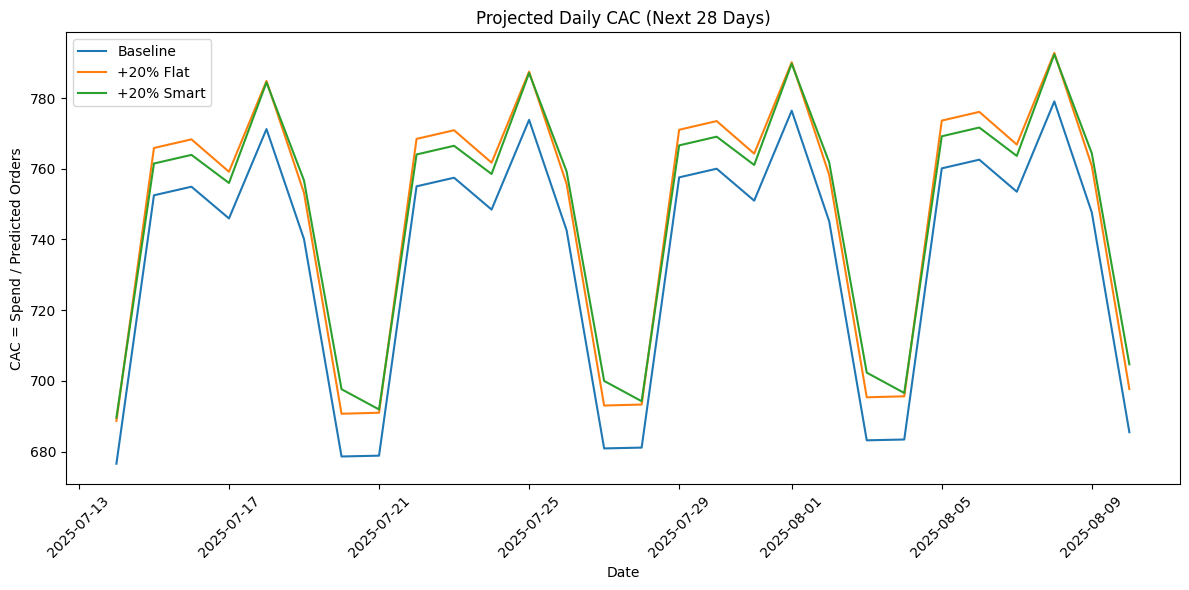

In [4]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ---- Load ----
path_opts = [
    "wbr_global_data.csv",
]
for p in path_opts:
    if os.path.exists(p):
        PATH = p; break

df = pd.read_csv(PATH)
df.columns = [c.lower() for c in df.columns]
df["ds"] = pd.to_datetime(df["date"])
df = df.sort_values("ds")
data = df.rename(columns={"daily_spend":"spend"})[["ds","spend","orders"]].copy()
data["spend"]  = pd.to_numeric(data["spend"], errors="coerce").clip(lower=0)
data["orders"] = pd.to_numeric(data["orders"], errors="coerce").clip(lower=0)
data["cac"]    = np.where(data["orders"]>0, data["spend"]/data["orders"], np.nan)

# ---- Weekday efficiency (inverse-CAC weights) ----
wk = (data.assign(weekday=data["ds"].dt.day_name())
           .groupby("weekday", as_index=False)
           .agg(cac_median=("cac","median")))
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
wk["weekday"] = pd.Categorical(wk["weekday"], categories=order, ordered=True)
wk = wk.sort_values("weekday")
wk["w"] = 1.0 / wk["cac_median"].replace(0, np.nan)
wk["w"] = wk["w"].fillna(wk["w"].median())
wk["w"] = wk["w"] / wk["w"].sum()
wmap = dict(zip(wk["weekday"].astype(str), wk["w"]))

# ---- Baseline spend template (last 28d median per weekday) ----
recent = data[data["ds"] >= data["ds"].max() - pd.Timedelta(days=27)]
base_map = (recent.assign(weekday=recent["ds"].dt.day_name())
                  .groupby("weekday", as_index=False)
                  .agg(baseline=("spend","median")))
base_map["weekday"] = pd.Categorical(base_map["weekday"], categories=order, ordered=True)
base_map = base_map.sort_values("weekday")
base_spend = dict(zip(base_map["weekday"].astype(str), base_map["baseline"]))

# ---- Scenarios ----
H = 28
future = pd.DataFrame({"ds": pd.date_range(start=data["ds"].max()+pd.Timedelta(days=1), periods=H)})
future["weekday"] = future["ds"].dt.day_name()

scenA = future.copy(); scenA["spend"] = scenA["weekday"].map(base_spend)
scenB = future.copy(); scenB["spend"] = scenB["weekday"].map(base_spend) * 1.20
totB = scenB["spend"].sum()
daily_w = future["weekday"].map(wmap).values; daily_w = daily_w/daily_w.sum()
scenC = future.copy(); scenC["spend"] = totB * daily_w

# ---- Model: Prophet if available, else ridge ----
def have_prophet():
    try:
        from prophet import Prophet; return True
    except Exception:
        try:
            from fbprophet import Prophet; return True
        except Exception:
            return False

def predict_orders_prophet(history, scen_dict):
    from prophet import Prophet
    m = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    m.add_regressor("spend")
    train = history.rename(columns={"orders":"y"})[["ds","y","spend"]]
    m.fit(train)
    out = {}
    for k, f in scen_dict.items():
        fc = m.predict(f[["ds","spend"]])
        o = f.copy()
        o["pred_orders"] = fc["yhat"].clip(lower=0)
        out[k] = o
    return out, "Prophet"

def predict_orders_reg(history, scen_dict):
    from sklearn.linear_model import Ridge
    h = history.copy()
    h["trend"] = (h["ds"] - h["ds"].min()).dt.days
    h["dow"] = h["ds"].dt.dayofweek
    X = pd.get_dummies(h[["trend","dow"]].astype({"dow":"category"}), drop_first=True)
    X["log_spend"] = np.log1p(h["spend"])
    y = np.log1p(h["orders"])
    mdl = Ridge(alpha=1.0).fit(X, y)
    out = {}
    for k, f in scen_dict.items():
        g = f.copy()
        g["trend"] = (g["ds"] - h["ds"].min()).dt.days
        g["dow"] = g["ds"].dt.dayofweek
        Xf = pd.get_dummies(g[["trend","dow"]].astype({"dow":"category"}), drop_first=True)
        for col in X.columns:
            if col not in Xf.columns: Xf[col] = 0
        Xf = Xf[X.columns]; Xf["log_spend"] = np.log1p(g["spend"])
        g["pred_orders"] = np.expm1(mdl.predict(Xf)).clip(min=0)
        out[k] = g
    return out, "Ridge"

scenarios = {"Baseline":scenA, "+20% Flat":scenB, "+20% Smart":scenC}
preds, model_name = (predict_orders_prophet(data, scenarios) if have_prophet()
                     else predict_orders_reg(data, scenarios))

# ---- Summaries ----
rows = []
for k, d in preds.items():
    tot_spend = d["spend"].sum()
    tot_orders = d["pred_orders"].sum()
    cac = tot_spend / tot_orders if tot_orders>0 else np.nan
    rows.append({"Scenario":k,"HorizonDays":H,"TotalSpend":round(tot_spend,2),
                 "PredOrders":round(tot_orders,1),"ProjectedCAC":round(cac,2)})
summary = pd.DataFrame(rows).sort_values("Scenario"); print(model_name); print(summary)

# ---- Plot ----
plt.figure(figsize=(12,6))
for k, d in preds.items():
    plt.plot(d["ds"], d["spend"]/d["pred_orders"], label=k)
plt.title("Projected Daily CAC (Next 28 Days)")
plt.xlabel("Date"); plt.ylabel("CAC = Spend / Predicted Orders"); plt.legend(); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()
